In [1]:
# Import libraries
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

# Notebook settings
sns.set(style='whitegrid', context='talk')
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Load Apple Health export
xml_file = 'export.xml'
tree = ET.parse(xml_file)
root = tree.getroot()

records = []
for record in root.findall('Record'):
    if record.get('type') == 'HKCategoryTypeIdentifierSleepAnalysis':
        records.append({
            'startDate': record.get('startDate'),
            'endDate': record.get('endDate'),
            'value': record.get('value')  # sleep category (in-bed, asleep, etc.)
        })

sleep_df = pd.DataFrame(records)
sleep_df['startDate'] = pd.to_datetime(sleep_df['startDate'])
sleep_df['endDate'] = pd.to_datetime(sleep_df['endDate'])
sleep_df['duration_hours'] = (sleep_df['endDate'] - sleep_df['startDate']).dt.total_seconds() / 3600
sleep_df['date'] = sleep_df['startDate'].dt.date

sleep_df.head()


,startDate,endDate,value,duration_hours,date
0,2024-07-28 23:18:00-04:00,2024-07-29 05:42:00-04:00,HKCategoryValueSleepAnalysisAsleepUnspecified,6.400000,2024-07-28
1,2024-07-28 23:18:00-04:00,2024-07-29 05:42:00-04:00,HKCategoryValueSleepAnalysisAsleepUnspecified,6.400000,2024-07-28
2,2024-07-29 22:42:00-04:00,2024-07-30 05:41:00-04:00,HKCategoryValueSleepAnalysisAsleepUnspecified,6.983333,2024-07-29
3,2024-07-29 22:42:00-04:00,2024-07-30 05:41:00-04:00,HKCategoryValueSleepAnalysisAsleepUnspecified,6.983333,2024-07-29
4,2024-07-29 22:42:00-04:00,2024-07-30 05:41:00-04:00,HKCategoryValueSleepAnalysisAsleepUnspecified,6.983333,2024-07-29


In [3]:
# Normalize sleep types
sleep_df['sleep_type'] = sleep_df['value'].apply(lambda x: x.split('.')[-1] if x else 'Unknown')

# Aggregate per night
daily_sleep = (
    sleep_df.groupby(['date', 'sleep_type'])['duration_hours']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

# Calculate total sleep per night
daily_sleep['total_sleep_hours'] = daily_sleep.sum(axis=1, numeric_only=True)
daily_sleep.head()


sleep_type,date,HKCategoryValueSleepAnalysisAsleepCore,HKCategoryValueSleepAnalysisAsleepDeep,HKCategoryValueSleepAnalysisAsleepREM,HKCategoryValueSleepAnalysisAsleepUnspecified,HKCategoryValueSleepAnalysisAwake,total_sleep_hours
0,2024-07-28,0.0,0.0,0.0,12.800000,0.0,12.800000
1,2024-07-29,0.0,0.0,0.0,20.950000,0.0,20.950000
2,2024-07-30,0.0,0.0,0.0,7.033333,0.0,7.033333
3,2024-07-31,0.0,0.0,0.0,10.866667,0.0,10.866667
4,2024-08-02,0.0,0.0,0.0,8.183333,0.0,8.183333


/Users/shaankohli/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128564 (\N{SLEEPING FACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


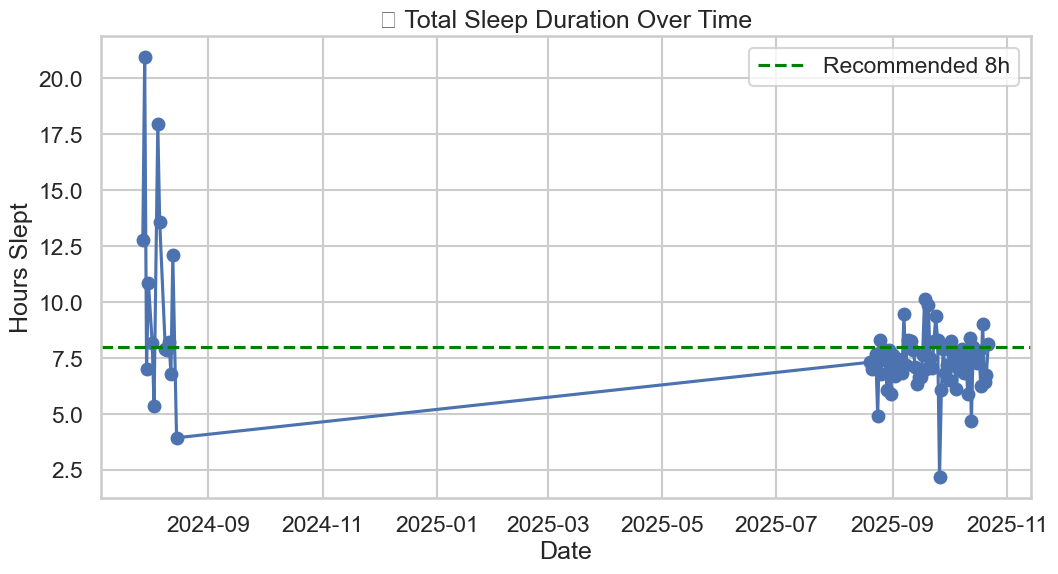

In [4]:
plt.plot(daily_sleep['date'], daily_sleep['total_sleep_hours'], marker='o')
plt.title("😴 Total Sleep Duration Over Time")
plt.xlabel("Date")
plt.ylabel("Hours Slept")
plt.axhline(8, color='green', linestyle='--', label='Recommended 8h')
plt.legend()
plt.show()


/var/folders/cc/lq3shpq136b5hm96sxn73pvw0000gn/T/ipykernel_17353/2598065381.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette='viridis')
/Users/shaankohli/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/shaankohli/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


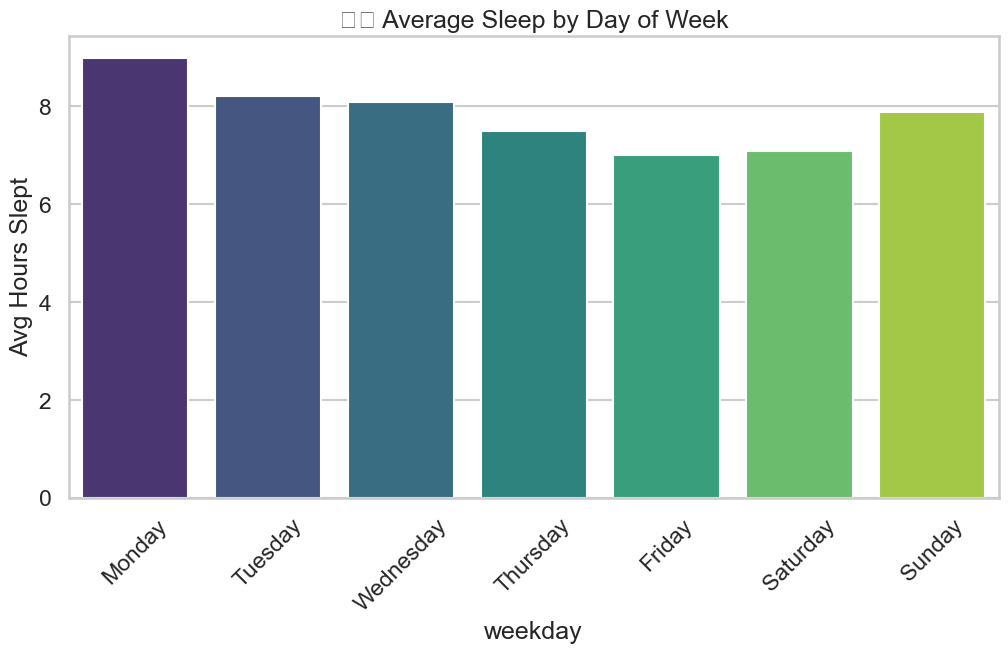

In [5]:
daily_sleep['weekday'] = pd.to_datetime(daily_sleep['date']).dt.day_name()
daily_sleep['week'] = pd.to_datetime(daily_sleep['date']).dt.isocalendar().week
daily_sleep['month'] = pd.to_datetime(daily_sleep['date']).dt.month_name()

# Average sleep by weekday
weekday_avg = daily_sleep.groupby('weekday')['total_sleep_hours'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette='viridis')
plt.title("🗓️ Average Sleep by Day of Week")
plt.ylabel("Avg Hours Slept")
plt.xticks(rotation=45)
plt.show()


In [6]:
avg_sleep = daily_sleep['total_sleep_hours'].mean()
std_sleep = daily_sleep['total_sleep_hours'].std()
cv_sleep = std_sleep / avg_sleep * 100

print(f"Average Sleep Duration: {avg_sleep:.2f} hours")
print(f"Standard Deviation: {std_sleep:.2f} hours")
print(f"Consistency (lower % = better): {cv_sleep:.1f}%")


Average Sleep Duration: 7.85 hours
Standard Deviation: 2.53 hours
Consistency (lower % = better): 32.2%


/var/folders/cc/lq3shpq136b5hm96sxn73pvw0000gn/T/ipykernel_17353/4109082657.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=phase_means.index, y=phase_means.values, palette='magma')
/Users/shaankohli/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128164 (\N{SLEEPING SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


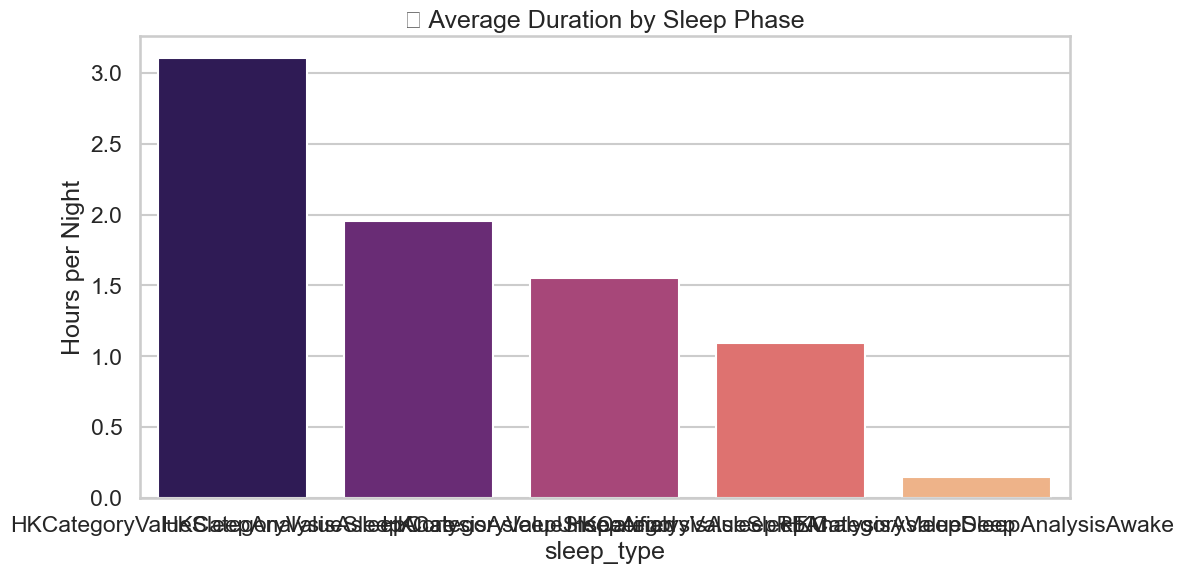

In [7]:
sleep_types = [col for col in daily_sleep.columns if col not in ['date', 'total_sleep_hours', 'weekday', 'week', 'month']]

phase_means = daily_sleep[sleep_types].mean().sort_values(ascending=False)

sns.barplot(x=phase_means.index, y=phase_means.values, palette='magma')
plt.title("💤 Average Duration by Sleep Phase")
plt.ylabel("Hours per Night")
plt.show()


/Users/shaankohli/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128368 (\N{MANTELPIECE CLOCK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/shaankohli/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


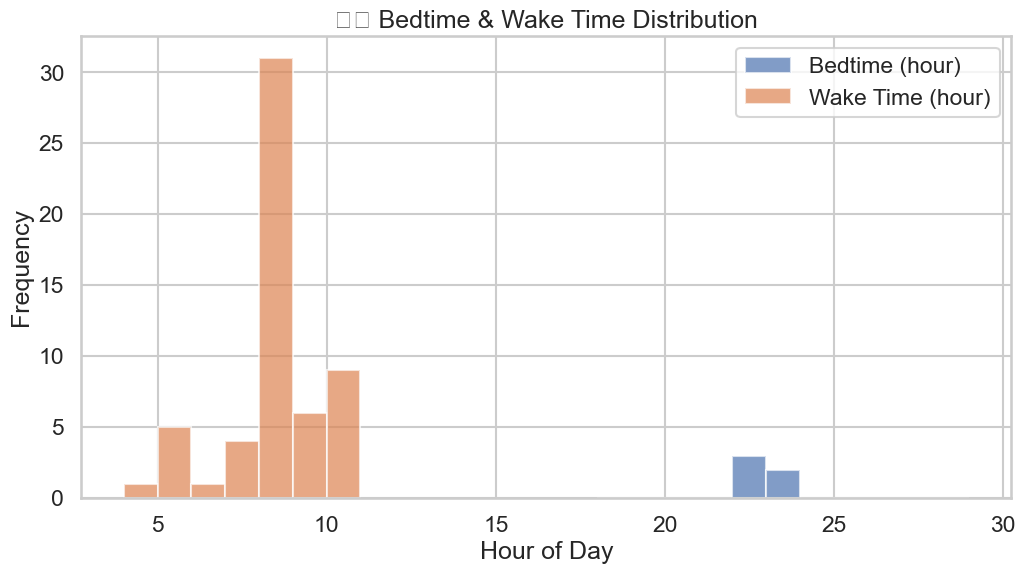

In [8]:
# Calculate sleep start and end times
sleep_df['start_time'] = sleep_df['startDate'].dt.time
sleep_df['end_time'] = sleep_df['endDate'].dt.time

bedtimes = sleep_df.groupby('date')['startDate'].min().dt.hour
wake_times = sleep_df.groupby('date')['endDate'].max().dt.hour

plt.hist(bedtimes, bins=range(18, 30), alpha=0.7, label='Bedtime (hour)')
plt.hist(wake_times, bins=range(4, 12), alpha=0.7, label='Wake Time (hour)')
plt.legend()
plt.title("🕰️ Bedtime & Wake Time Distribution")
plt.xlabel("Hour of Day")
plt.ylabel("Frequency")
plt.show()


/Users/shaankohli/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shaankohli/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shaankohli/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shaankohli/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given wit

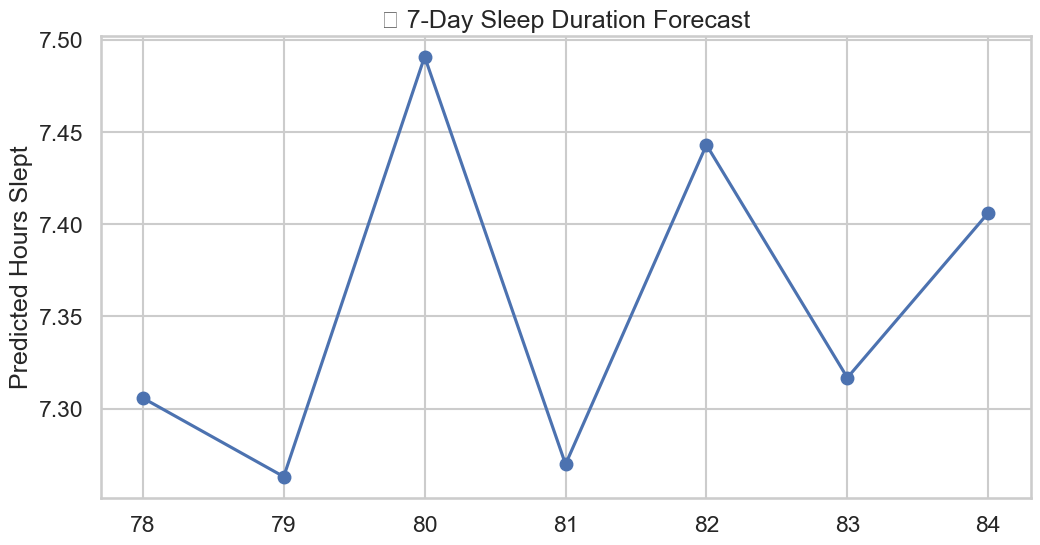

In [10]:
from statsmodels.tsa.arima.model import ARIMA

ts = daily_sleep.set_index('date')['total_sleep_hours']
model = ARIMA(ts, order=(2,1,2))
results = model.fit()

forecast = results.forecast(steps=7)
forecast.plot(marker='o', title='🧠 7-Day Sleep Duration Forecast')
plt.ylabel("Predicted Hours Slept")
plt.show()


In [11]:
insights = {
    "Average Sleep (hrs/night)": round(avg_sleep, 2),
    "Most Frequent Bedtime Hour": int(bedtimes.mode()[0]),
    "Most Frequent Wake Hour": int(wake_times.mode()[0]),
    "Consistency % (lower=better)": round(cv_sleep, 1)
}

print("🧠 Key Sleep Insights:")
for k, v in insights.items():
    print(f" - {k}: {v}")


🧠 Key Sleep Insights:
 - Average Sleep (hrs/night): 7.85
 - Most Frequent Bedtime Hour: 0
 - Most Frequent Wake Hour: 8
 - Consistency % (lower=better): 32.2
